In [1]:
#imports
import spatialdata
import dask_image.imread
import dask.array as da
import geopandas as gpd
import anndata as ad
import napari_spatialdata
import time

import sys, os
sys.path.append(os.path.abspath("../functions/"))
import filtering
import anndata_utils

for package in [spatialdata, gpd, ad, napari_spatialdata]:
    print(f"{package.__name__}: {package.__version__}")

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


spatialdata: 0.2.3
geopandas: 1.0.1
anndata: 0.11.3
napari_spatialdata: 0.5.3


In [2]:
# load sdata
sdata = spatialdata.read_zarr("../data/TNBC_subset/sdata.zarr")
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/TNBC_subset/sdata.zarr
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels)

In [3]:
sdata['imaging'].var

,math,marker
mean_750_bg,mean,750_bg
mean_647_bg,mean,647_bg
mean_555_bg,mean,555_bg
mean_488_bg,mean,488_bg
mean_DAPI_bg,mean,DAPI_bg
mean_Vimentin,mean,Vimentin
mean_CD3e,mean,CD3e
mean_panCK,mean,panCK
mean_CD8,mean,CD8
mean_DAPI_1,mean,DAPI_1


# Filter by value threshold in a feature

In [4]:
feature_to_filter = "mean_DAPI_bg"

### Explore values of cells for DNA_6 feature

In [5]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

def plot_dynamic_histogram(df, column, bins=100):
    """
    Create a dynamic histogram with a threshold slider, 
    showing counts to the left and right of the threshold.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to plot.
    """
    # Validate input
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    data = df[column].dropna()  # Handle missing values
    if data.empty:
        raise ValueError(f"No valid data in column '{column}'.")

    # Initial threshold
    initial_threshold = data.mean()  # Start at the mean as default

    # Function to calculate counts based on threshold
    def calculate_counts(data, threshold):
        left_count = (data < threshold).sum()
        right_count = (data >= threshold).sum()
        return left_count, right_count

    # Initial counts
    left_count, right_count = calculate_counts(data, initial_threshold)

    # Create figure
    fig = go.Figure()

    # Add histogram trace
    fig.add_trace(go.Histogram(x=data, nbinsx=bins, name=column))

    # Add initial annotations for counts
    fig.update_layout(
        annotations=[dict(x=0.02, y=1.1, xref="paper", yref="paper", text=f"Left Count: {left_count}", showarrow=False),
                    dict(x=0.98, y=1.1, xref="paper", yref="paper", text=f"Right Count: {right_count}", showarrow=False)]
    )

    # Initial vertical line at threshold
    fig.add_shape(
        type="line",
        x0=initial_threshold, y0=0, x1=initial_threshold, y1=1,
        xref="x", yref="paper",
        line=dict(color="red", width=2, dash="dash")
    )

    # Function to update both the annotations and line
    def update_slider(threshold):
        # Update counts
        left_count, right_count = calculate_counts(data, threshold)
        # Update annotations
        annotations = [
            dict(x=0.02, y=1.1, xref="paper", yref="paper", text=f"Left Count: {left_count}", showarrow=False),
            dict(x=0.98, y=1.1, xref="paper", yref="paper", text=f"Right Count: {right_count}", showarrow=False)]
        # Update line position
        shapes = [dict(
            type="line",
            x0=threshold, y0=0, x1=threshold, y1=1,
            xref="x", yref="paper",
            line=dict(color="red", width=2, dash="dash"))]
        return {"annotations": annotations, "shapes": shapes}

    # Add slider with threshold steps
    thresholds = np.linspace(data.min(), data.max(), bins)
    fig.update_layout(
        sliders=[{
            "active": 0,
            "currentvalue": {"prefix": "Threshold: "},
            "pad": {"t": 50},
            "steps": [
                {
                    "label": str(round(threshold, 2)),
                    "method": "relayout",
                    "args": [update_slider(threshold)]
                }
                for threshold in thresholds
            ]
        }]
    )

    # Show figure
    fig.show()

In [6]:
df = pd.DataFrame(data=sdata['imaging'].X, columns=sdata['imaging'].var_names)
plot_dynamic_histogram(df, feature_to_filter, bins=300)

In [7]:
# I decided from histogram that 6 is a good min threshold for the DNA_6 feature.
# I decided from histogram that 50 is a good max threshold for the DNA_6 feature. 
# I will now filter the data based on this threshold.

### Filtering by absolute value

In [7]:
# now visualize in sdata
sdata['imaging'] = filtering.filter_by_abs_value(
    adata=sdata['imaging'], 
    marker=feature_to_filter,
    value=6,
    direction='above',
    plot=False)

2025-02-04 07:34:18.219 | INFO     | filtering:filter_by_abs_value:38 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-02-04 07:34:18.227 | INFO     | filtering:filter_by_abs_value:72 - Number of cells with mean_DAPI_bg above 6: 16794
2025-02-04 07:34:18.228 | INFO     | filtering:filter_by_abs_value:87 -  ---- filter_by_abs_value is done, took 0s  ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [8]:
sdata['imaging'] = filtering.filter_by_abs_value(
    adata=sdata['imaging'], 
    marker=feature_to_filter,
    value=50,
    direction='below',
    plot=False)

2025-02-04 07:34:29.274 | INFO     | filtering:filter_by_abs_value:38 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-02-04 07:34:29.278 | INFO     | filtering:filter_by_abs_value:72 - Number of cells with mean_DAPI_bg below 50: 16692
2025-02-04 07:34:29.278 | INFO     | filtering:filter_by_abs_value:87 -  ---- filter_by_abs_value is done, took 0s  ----
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [10]:
# since two filters were applied, let's merge them
sdata['imaging'].obs['DNA_filter'] = sdata['imaging'].obs[f'mean_DAPI_bg_above_6'] & sdata['imaging'].obs['mean_DAPI_bg_below_50']

In [11]:
sdata['imaging'].obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,mean_DAPI_bg_above_6,mean_DAPI_bg_below_50,DNA_filter
0,0,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,True,True,True
1,1,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,True,True,True
2,2,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,True,True,True
3,3,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,True,True,True
4,4,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,True,True,True


## Filter by ratio between two values 

In [13]:
sdata['imaging'].var

,math,marker
mean_750_bg,mean,750_bg
mean_647_bg,mean,647_bg
mean_555_bg,mean,555_bg
mean_488_bg,mean,488_bg
mean_DAPI_bg,mean,DAPI_bg
mean_Vimentin,mean,Vimentin
mean_CD3e,mean,CD3e
mean_panCK,mean,panCK
mean_CD8,mean,CD8
mean_DAPI_1,mean,DAPI_1


In [14]:
# explore the data
df = pd.DataFrame(data=sdata['imaging'].X, columns=sdata['imaging'].var_names)
df['DNA_ratio'] = df['mean_DAPI_2'] / df['mean_DAPI_bg']
plot_dynamic_histogram(df, "DNA_ratio", bins=300) #log scale would be a bit better

2025-02-04 07:38:05.704 | INFO     | filtering:filter_by_ratio:93 -  ---- filter_by_ratio : version number 1.1.0 ----
2025-02-04 07:38:05.711 | INFO     | filtering:filter_by_ratio:111 - Number of cells with DAPI ratio < 0.3: 1113
2025-02-04 07:38:05.713 | INFO     | filtering:filter_by_ratio:112 - Number of cells with DAPI ratio > 0.8: 171
2025-02-04 07:38:05.717 | INFO     | filtering:filter_by_ratio:113 - Number of cells with DAPI ratio between 0.3 and 0.8: 15524
2025-02-04 07:38:05.723 | INFO     | filtering:filter_by_ratio:114 - Percentage of cells filtered out: 7.64%


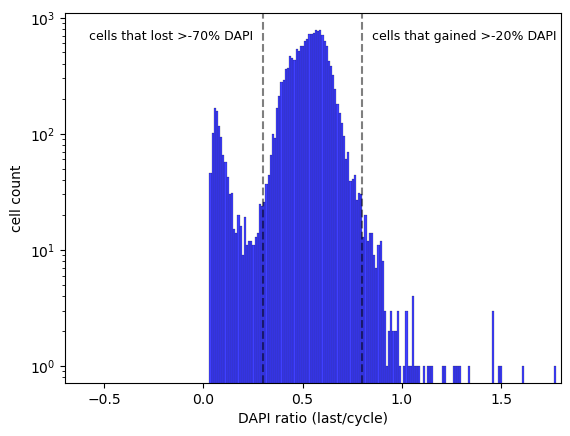

2025-02-04 07:38:06.134 | INFO     | filtering:filter_by_ratio:134 -  ---- filter_by_ratio is done, took 0s  ----


In [15]:
adata = filtering.filter_by_ratio(
    sdata['imaging'],
    end_cycle='mean_DAPI_2', 
    start_cycle="mean_DAPI_bg", 
    label="DAPI", 
    min_ratio=0.3, max_ratio=0.8)

In [16]:
adata.obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,mean_DAPI_bg_above_6,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass
0,0,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,True,True,True,0.065991,False,True,False
1,1,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,True,True,True,0.107462,False,True,False
2,2,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,True,True,True,0.098039,False,True,False
3,3,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,True,True,True,0.136228,False,True,False
4,4,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,True,True,True,0.104794,False,True,False


## Filter by manual annotations

2025-02-04 07:46:32.524 | INFO     | filtering:filter_by_annotation:141 -  ---- filter_by_annotation : version number 1.3.0 ----
2025-02-04 07:46:32.808 | INFO     | filtering:filter_by_annotation:148 - GeoJson loaded, detected: 8 annotations
2025-02-04 07:46:32.934 | INFO     | filtering:filter_by_annotation:178 - Found 2 unique classes in the geojson file: ['folded_tissue' 'Antibody_clumps']


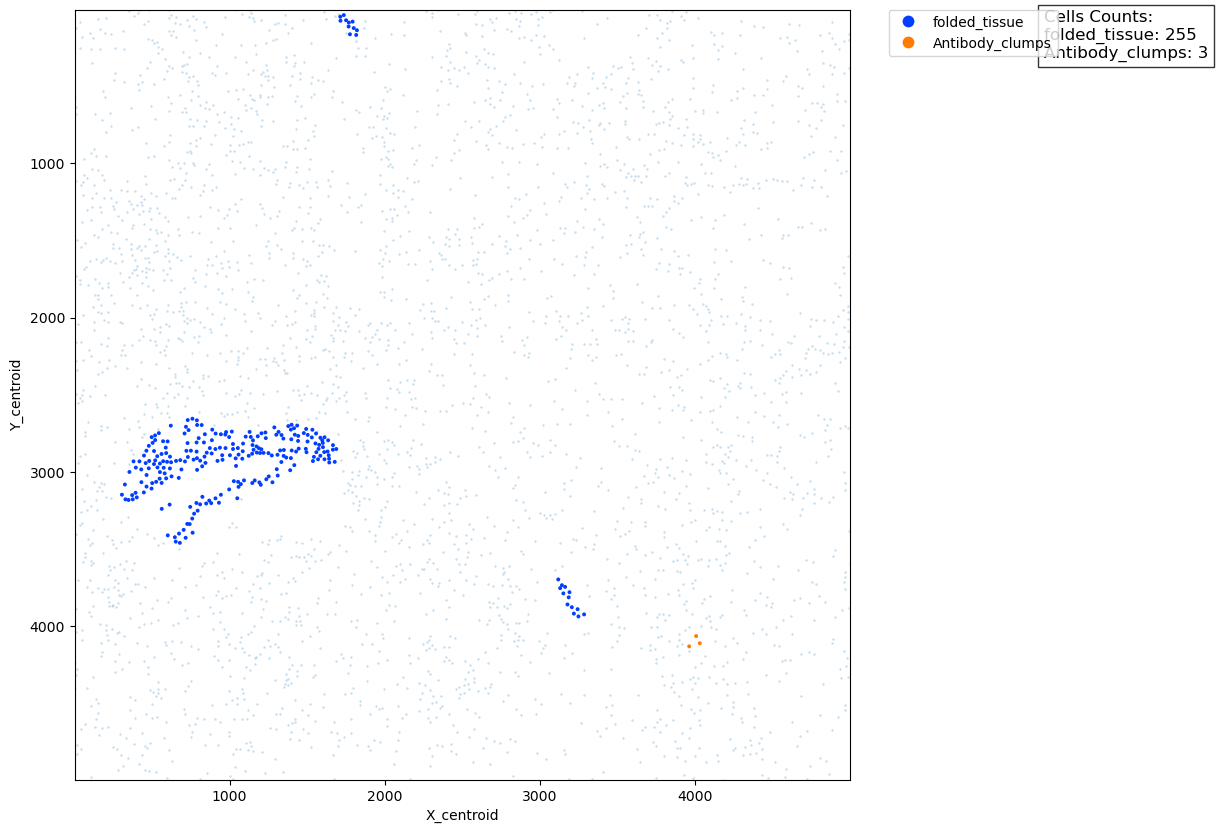

2025-02-04 07:46:36.497 | INFO     | filtering:filter_by_annotation:214 -  ---- filter_by_annotation is done, took 3s  ----


In [17]:
#needs geojson file, with some classifications
adata = filtering.filter_by_annotation(
    adata=sdata['imaging'],
    path_to_geojson="../data/TNBC_subset/TD_15_TNBC_subset_artefact_annotations.geojson")

In [18]:
sdata['imaging'].obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,mean_DAPI_bg_above_6,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,folded_tissue,Antibody_clumps
0,0,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,True,True,True,0.065991,False,True,False,False,False
1,1,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,True,True,True,0.107462,False,True,False,False,False
2,2,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,True,True,True,0.098039,False,True,False,False,False
3,3,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,True,True,True,0.136228,False,True,False,False,False
4,4,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,True,True,True,0.104794,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16803,16803,4993.579685,106.373030,571.0,52.291050,14.719719,0.959562,-1.563557,116.870058,0.976068,True,True,True,0.209647,False,True,False,False,False
16804,16804,4993.413242,810.385845,438.0,40.105247,14.334812,0.933940,1.531591,90.970563,0.962637,True,True,True,0.477926,True,True,True,False,False
16805,16805,4994.153535,645.010101,495.0,50.864135,13.112118,0.966202,1.538209,111.248737,0.951923,True,True,True,0.268536,False,True,False,False,False
16806,16806,4993.835570,1244.718121,298.0,28.947821,13.495126,0.884686,-1.561806,69.213203,0.973856,True,True,True,0.523596,True,True,True,False,False


## QC2: visualize the filtered cells

### Preparation 1: Transform the segmentation mask into polygons

In [19]:
# create shapes from mask
mask_polygons = spatialdata.to_polygons(sdata['mask'])
sdata['mask_polygons'] = spatialdata.models.ShapesModel.parse(mask_polygons)
# important to have same number of cells in imaging and mask
assert sdata['imaging'].shape[0] == sdata['mask_polygons'].shape[0], "Number of cells in imaging and mask do not match."
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/TNBC_subset/sdata.zarr
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (16808, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ mask_polygons (Shapes)

### Preparation 2: Link quantification table to polygons

We now have to match the index of "sdata['mask_polygons']" to a column in adata.obs; this will be CellID, lets confirm they match

In [24]:
sdata['imaging'].obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,mean_DAPI_bg_above_6,mean_DAPI_bg_below_50,DNA_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,folded_tissue,Antibody_clumps
0,1,17.612598,53.337008,1270.0,48.198269,36.841132,0.644782,0.359469,146.669048,0.949178,True,True,True,0.065991,False,True,False,False,False
1,2,6.598958,126.006944,576.0,45.835698,18.372329,0.916152,1.513685,113.112698,0.886154,True,True,True,0.107462,False,True,False,False,False
2,3,17.416667,156.656504,984.0,40.751104,31.700565,0.628380,-1.528462,121.396970,0.955340,True,True,True,0.098039,False,True,False,False,False
3,4,4.982558,179.337209,344.0,34.620290,13.577757,0.919884,1.474818,82.627417,0.971751,True,True,True,0.136228,False,True,False,False,False
4,5,19.159558,228.598210,1899.0,54.446578,49.053930,0.433912,1.287374,196.610173,0.896601,True,True,True,0.104794,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16803,16804,4993.579685,106.373030,571.0,52.291050,14.719719,0.959562,-1.563557,116.870058,0.976068,True,True,True,0.209647,False,True,False,False,False
16804,16805,4993.413242,810.385845,438.0,40.105247,14.334812,0.933940,1.531591,90.970563,0.962637,True,True,True,0.477926,True,True,True,False,False
16805,16806,4994.153535,645.010101,495.0,50.864135,13.112118,0.966202,1.538209,111.248737,0.951923,True,True,True,0.268536,False,True,False,False,False
16806,16807,4993.835570,1244.718121,298.0,28.947821,13.495126,0.884686,-1.561806,69.213203,0.973856,True,True,True,0.523596,True,True,True,False,False


In [23]:
#check if CellID starts at 0, if so, add 1 to all CellIDs
if sdata['imaging'].obs['CellID'][0] == 0:
    sdata['imaging'].obs['CellID'] = sdata['imaging'].obs['CellID'] + 1

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_6956/2057907485.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [21]:
sdata['mask_polygons']

,label,geometry
label,,
1,1,"POLYGON ((60 43.5, 59 43.5, 58 43.5, 57 43.5, ..."
2,2,"POLYGON ((134 19.5, 133 19.5, 132 19.5, 131 19..."
3,3,"POLYGON ((156 33.5, 155 33.5, 154 33.5, 153 33..."
4,4,"POLYGON ((188 13.5, 187 13.5, 186 13.5, 185 13..."
5,5,"POLYGON ((235 48.5, 234 48.5, 233 48.5, 232.5 ..."
...,...,...
16804,16804,"POLYGON ((133 5000.5, 132 5000.5, 131 5000.5, ..."
16805,16805,"POLYGON ((830 5000.5, 829 5000.5, 828 5000.5, ..."
16806,16806,"POLYGON ((671 5000.5, 670 5000.5, 669 5000.5, ..."


In [25]:
assert sdata['mask_polygons'].index.to_list()[:5] == sdata['imaging'].obs['CellID'].to_list()[:5], "First 5 CellIDs do not match."
assert sdata['mask_polygons'].index.to_list()[-5:] == sdata['imaging'].obs['CellID'].to_list()[-5:], "Last 5 CellIDs do not match."
assert sdata['mask_polygons'].index.dtype == sdata['imaging'].obs['CellID'].dtype, "Data types do not match."

In [26]:
adata.obs["shapes"] = "mask_polygons"
adata.obs["shapes"] = adata.obs["shapes"].astype("category")
table = spatialdata.models.TableModel.parse(adata, region = "mask_polygons", region_key = "shapes", instance_key = "CellID")
sdata["imaging"] = table

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/spatialdata/_core/_elements.py:116: UserWarning:

Key `imaging` already exists. Overwriting it in-memory.



In [27]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/TNBC_subset/sdata.zarr
├── Images
│     └── 'image': DataArray[cyx] (15, 5000, 5000)
├── Labels
│     └── 'mask': DataArray[yx] (5000, 5000)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (16808, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (16808, 15)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), mask (Labels), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ mask_polygons (Shapes)

### Visualized filtered cells

In [28]:
# QC2 Visual check of filtered cells
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()

# Issue 1
# sdata['mask'] is not available in napari-spatialdata
# Issue 2
# unfortunately color palettes are still not available 
# See issue: https://github.com/scverse/napari-spatialdata/issues/324

In [30]:
sdata.write("../data/TNBC_subset/sdata_filtered.zarr")

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside ../data/TNBC_subset/sdata_filtered.zarr). Please see the documentation of               
         `is_self_contained()` to understand the implications of working with SpatialData objects that are not     
         self-contained.                                                                                           
INFO     The Zarr backing store has been changed from ../data/TNBC_subset/sdata.zarr the new file path:            
         ../data/TNBC_subset/sdata_filtered.zarr                                                                   
